# OP2: Numpy Demo #2 (Composite Plate Stress)

The Jupyter notebook for this demo can be found in:
   - docs/quick_start/demo/op2_demo_numpy1.ipynb
   - https://github.com/SteveDoyle2/pyNastran/tree/master/docs/quick_start/demo/op2_demo_numpy1.ipynb

It's recommended that you first go through:
   - https://github.com/SteveDoyle2/pyNastran/tree/master/docs/quick_start/demo/op2_demo.ipynb
   - https://github.com/SteveDoyle2/pyNastran/tree/master/docs/quick_start/demo/op2_demo_numpy1.ipynb

In this tutorial, composite plate stresses will be covered.

## Load the model

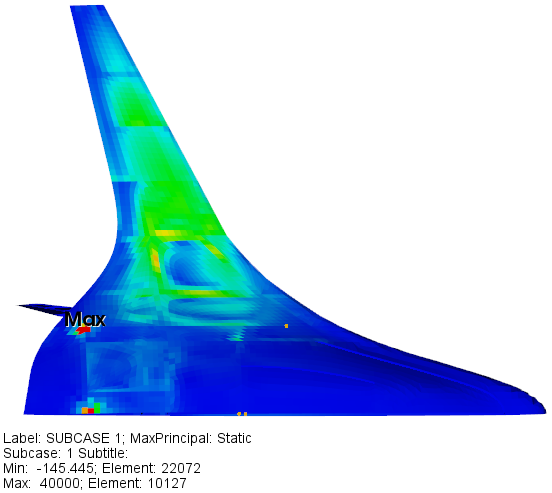

If the BWB example OP2 doesn't exist, we'll run Nastran to create it.

In [1]:
import os
import copy
import shutil
import numpy as np
np.set_printoptions(precision=2, threshold=20, linewidth=100, suppress=True)

import pyNastran
from pyNastran.op2.op2 import read_op2
from pyNastran.utils.nastran_utils import run_nastran
pkg_path = pyNastran.__path__[0]
#pkg_path = r'C:\Users\sdoyle\Desktop\demo\pyNastran\pyNastran'
model_path = os.path.join(pkg_path, '..', 'models')

bdf_filename = os.path.join(model_path, 'bwb', 'bwb_saero.bdf')
op2_filename = os.path.join(model_path, 'bwb', 'bwb_saero.op2')
if not os.path.exists(op2_filename):
    keywords = ['scr=yes', 'bat=no', 'old=no']
    run_nastran(bdf_filename, nastran_cmd='nastran', keywords=keywords, run=True)
    op2_filename2 = os.path.join('bwb_saero.op2')
    shutil.move(op2_filename2, op2_filename)

assert os.path.exists(op2_filename), print_bad_path(op2_filename)
model = read_op2(op2_filename, build_dataframe=False, debug=False)

print(model.get_op2_stats(short=True))

op2_results.force.cbar_force[1]
op2_results.force.ctria3_force[1]
op2_results.force.cquad4_force[1]
op2_results.stress.cbar_stress[1]
op2_results.stress.cquad4_composite_stress[1]
op2_results.stress.ctria3_composite_stress[1]
op2_results.strain.cbar_strain[1]
op2_results.strain.cquad4_composite_strain[1]
op2_results.strain.ctria3_composite_strain[1]
displacements[1]
spc_forces[1]
grid_point_forces[1]



### Accessing the Composite Stress

Let's get the max principal stress.

In [2]:
isubcase = 1
op2_results = model.op2_results
stress = op2_results.stress
stressi = stress.cquad4_composite_stress[isubcase]
print(stressi)
headers = stressi.get_headers()
imax = headers.index('major')

  type=RealCompositePlateStressArray nelements=9236 ntotal=92360
  data: [1, ntotal, 9] where 9=[o11, o22, t12, t1z, t2z, angle, major, minor, max_shear]
  element_layer.shape = (92360, 2)
  data.shape = (1, 92360, 9)
  element type: QUAD4LC-composite-95
  sort1
  lsdvmns = [1]; dtype=int64



#### Composite Stress/Strain data is tricky to access as there is not a good way to index the data

Let's cheat a bit using the element ids and layers to make a pivot table.
 - **table** is (ntimes, nelements, nlayers, ndata) 
 - **max_principal_stress_table** is (nelements, nlayers)
 
 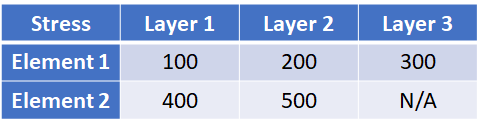

In [3]:
print('Element, Layer')
print(stressi.element_layer)

Element, Layer
[[ 1001     1]
 [ 1001     2]
 [ 1001     3]
 ...
 [22050     8]
 [22050     9]
 [22050    10]]


In [4]:
from pyNastran.femutils.utils import pivot_table

## now pivot the stress
eids = stressi.element_layer[:, 0]
layers = stressi.element_layer[:, 1]
table, rows_new = pivot_table(stressi.data, eids, layers)

# now access the max principal stress for the static result
# table is (itime, nelements, nlayers, data)
itime = 0
max_principal_stress_table = table[itime, :, :, imax]
ueids = np.unique(eids)
print('max_principal_stress_table:\n%s' % max_principal_stress_table)

max_principal_stress_table:
[[ 235.29  161.24   95.75 ...  -24.66  -24.58  -10.78]
 [  16.77   75.67   22.95 ...  -56.91  -56.5    -3.56]
 [   2.87  103.14   46.78 ... -129.44 -120.5   -34.82]
 ...
 [ 156.04  169.48  112.44 ...   44.56   47.04   39.24]
 [ 123.26  142.38   97.18 ...   41.02   43.96   42.92]
 [  89.85  109.55   79.73 ...   33.28   36.07   24.61]]


## More realistic pivot table
All the elements have 10 layers.  Let's remove the last 5 layers of the last element.

By having empty layers, the pivot table now has nan data in it.

In [5]:
# drop out 5 layers
eids2 = stressi.element_layer[:-5, 0]
layers2 = stressi.element_layer[:-5, 1]
data2 = stressi.data[:, :-5, :]

# now pivot the stress
table, rows_new = pivot_table(data2, eids2, layers2)

# access the table data
# table is (itime, nelements, nlayers, data)
itime = 0
max_principal_stress_table2 = table[itime,:,:,imax]
print('max_principal_stress_table2:\n%s' % max_principal_stress_table2)

max_principal_stress_table2:
[[ 235.29  161.24   95.75 ...  -24.66  -24.58  -10.78]
 [  16.77   75.67   22.95 ...  -56.91  -56.5    -3.56]
 [   2.87  103.14   46.78 ... -129.44 -120.5   -34.82]
 ...
 [ 156.04  169.48  112.44 ...   44.56   47.04   39.24]
 [ 123.26  142.38   97.18 ...   41.02   43.96   42.92]
 [  89.85  109.55   79.73 ...     nan     nan     nan]]


### Grid Point Forces - Interface Loads
We need some more data from the geometry

In [6]:
import pyNastran
from pyNastran.bdf.bdf import read_bdf
bdf_model = read_bdf(bdf_filename)

out = bdf_model.get_displacement_index_xyz_cp_cd()
icd_transform, icp_transform, xyz_cp, nid_cp_cd = out
nids = nid_cp_cd[:, 0]
nid_cd = nid_cp_cd[:, [0, 2]]
xyz_cid0 = bdf_model.transform_xyzcp_to_xyz_cid(
    xyz_cp, nids, icp_transform,
    cid=0)
del nids, out

In [7]:
from pyNastran.bdf.utils import parse_patran_syntax_dict
elems_nids = (
    'Elem 1396 1397 1398 1399 1418 1419 1749 1750 1751 1752 2010 2011 2012 2620 2621 2639 2640 2641 1247:1251 1344:1363 1372:1380 1526:1536 1766:1774 1842:1851 2141:2152 2310:2321 2342:2365 2569:2577 2801:2956 3081:3246 3683:3742 3855:3920 4506:4603 4968:5047 5070:5175 5298:5469 5494:5565 5837:5954 '
    'Node 2795 2796 2797 2798 3104 3106 3107 3132 3133 3135 3136 3137 3746 3747 3748 3749 3751 3752 3753 3754 3756 3757 3758 3759 3761 3762 3763 3764 3766 3767 3768 3769 3771 3772 3773 3774 3776 3777 3778 3779 3781 3782 3783 3784 3791 3792 3793 3796 3797 3798 3801 3802 3803 3806 3807 3808 3811 3812 3813 3816 3817 3818 3821 3822 3823 3826 3827 3828 4334 4335 4336 4338 4339 4340 4343 4344 4347 4348 4350 4351 4352 4354 4355 4356 4359 4360 4363 4364 4367 4368 4371 4372 4374 4375 4376 4378 4379 4382 4383 4385 4386 4387 4389 4390 4391 4394 4395 4398 4399 4401 4402 4403 4405 4406 4407 4409 4410 4411 4413 4414 4415 4418 4419 4593 4594 4596 4597 4599 4600 4602 4603 4605 4606 4608 4609 4611 4612 4614 4615 4617 4618 4620 4621 5818 5819 5820 5822 5823 5824 5826 5827 5828 5830 5831 5832 5834 5835 5836 5838 5839 5840 5842 5843 5844 5846 5847 5848 5850 5851 5852 5854 5855 5856 5872 5873 5874 5876 5877 5878 5880 5881 5882 5884 5885 5886 5888 5889 5890 5892 5893 5894 5896 5897 5898 5900 5901 5902 5904 5905 5906 6203 6204 6205 6206 6208 6209 6210 6211 6213 6214 6215 6216 6218 6219 6220 6221 6223 6224 6225 6226 6228 6229 6230 6231 6233 6234 6235 6236 6238 6239 6240 6241 6243 6244 6245 6246 6255 6256 6257 6263 6264 6265 6266 6268 6269 6270 6271 6273 6274 6275 6276 6278 6279 6280 6281 6283 6284 6285 6286 6288 6289 6290 6291 6293 6294 6295 6296 6298 6299 6300 6301 6303 6304 6305 6306 6355 6356 6357 6359 6360 6361 6363 6364 6365 6367 6368 6369 6371 6372 6373 6375 6376 6377 6379 6380 6381 6383 6384 6385 6411 6412 6414 6415 6417 6418 6420 6421 6423 6424 6426 6427 6429 6430 6432 6433 6435 6436 6438 6439 6441 6442 6459 6460 6462 6463 6465 6466 6468 6469 6471 6472 6474 6475 6477 6478 6480 6481 6483 6484 6486 6487 6489 6490 1201506 1201531 1202016 1202039 1202764 1202767 1202768 1202770 1202771 1202773 1202774 1202776 1202779 1202780 1202782 1202783 1202785 1202786 1202788 1203040 1316:1327 1444:1473 1490:1507 1531:1538 1563:1567 1710:1729 2008:2016 2039:2054 2136:2153 2351:2356 2507:2528 2720:2729 2731:2735 2764:2793 3040:3055 3339:3346 3348:3355 3357:3364 3366:3373 3375:3382 3384:3391 3396:3406:2 3407:3414 3424:3431 3433:3440 3442:3449 3451:3458 3460:3467 3469:3476 3481:3491:2 3492:3499 3658:3668 3670:3680 3682:3692 3705:3715 3717:3727 3729:3739 4560:4589 5290:5298 5300:5308 5310:5318 5320:5328 5339:5347 5349:5357 5359:5367 5369:5377 5858:5870 5947:5994 6001:6005 6007:6011 6013:6017 6019:6023 6025:6029 6031:6035 6037:6041 6043:6047 6309:6314 6319:6350 6445:6455 6811:6819 6821:6829 6831:6839 6841:6849 6851:6859 6870:6878 6880:6888 6890:6898 6900:6908 6910:6918 1201316:1201326:2 1201464:1201473 1201533:1201537:2 1202041:1202053:2 1202136:1202152:2 1202351:1202355:2 1202507:1202527:2 1202731:1202735 1203042:1203052:2 1203424:1203431 1203433:1203440 1203442:1203449 1203451:1203458 1203460:1203467 1203469:1203476 1203481:1203491:2 1203492:1203499 1203705:1203715 1203717:1203727 1203729:1203739 1205339:1205347 1205349:1205357 1205359:1205367 1205369:1205377 1206870:1206878 1206880:1206888 1206890:1206898 1206900:1206908 1206910:1206918 '
)
# print(elems_nids)
data = parse_patran_syntax_dict(elems_nids)
eids = data['Elem']
nids = data['Node']
#print(data, type(data))

In [8]:
isubcase = 1
grid_point_forces = model.grid_point_forces[isubcase]
print(''.join(grid_point_forces.get_stats()))
#print(grid_point_forces.object_methods())

# global xyz
coords = bdf_model.coords

# some more data
coord_out = bdf_model.coords[0]
summation_point = [0., 0., 0.]
#summation_point = [1197.97, 704.153, 94.9258]  # ~center of interface line

log = bdf_model.log
force_sumi, moment_sumi = grid_point_forces.extract_interface_loads(
    nids, eids,
    coord_out, coords,
    nid_cd,
    icd_transform,
    xyz_cid0,
    summation_point=summation_point,
    consider_rxf=True,
    itime=0, debug=False, log=log)
# print(forcei, force_sumi)
# print(momenti, moment_sumi)

np.set_printoptions(precision=8, threshold=20, linewidth=100, suppress=True)
print(f'force  = {force_sumi}; total={np.linalg.norm(force_sumi):.2f}')
print(f'moment = {moment_sumi}; total={np.linalg.norm(moment_sumi):.2f}')

np.set_printoptions(precision=2, threshold=20, linewidth=100, suppress=True)


  type=RealGridPointForcesArray nelements=2 total=56033
  data: [1, ntotal, 6] where 6=[f1, f2, f3, m1, m2, m3]
  data.shape=(1, 56033, 6)
  element type: *TOTALS*, APP-LOAD, BAR, F-OF-MPC, F-OF-SPC, QUAD4, TRIA3
  sort1
  lsdvmns = [0]; dtype=int64

force  = [    -0.01953125     -0.0234375  126282.305     ]; total=126282.30
moment = [ 1.15019896e+08 -1.52693184e+08 -3.20000000e+01]; total=191166912.00


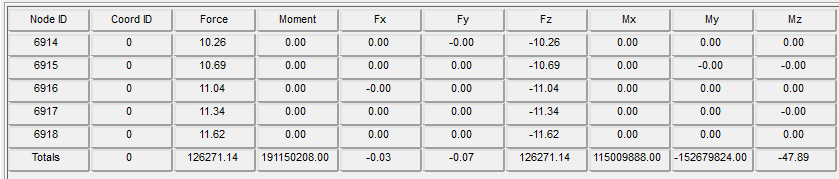